In [1]:
import os
import numpy as np
from pandas import DataFrame
import nibabel
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
from ia_mri_tools.ia_mri_tools import coil_correction, signal_likelihood, textures
from sklearn.covariance import EmpiricalCovariance
from sklearn.linear_model import LogisticRegression

In [2]:
# Load the data
data_path = 'data/HCP/100307'
t1 = nibabel.load(os.path.join(data_path, 'T1w_acpc_dc.nii.gz')).get_data()
t2 = nibabel.load(os.path.join(data_path, 'T2w_acpc_dc.nii.gz')).get_data()
nx, ny, nz = t1.shape

# Load the Freesurfer segmentation
seg = nibabel.load(os.path.join(data_path, 'aparc+aseg.nii.gz')).get_data()

# and label mapping
with open('../ia_mri_tools/freesurfer/FreeSurferColorLUT.txt', 'r') as f:
    labels = {}
    for line in f.readlines():
        try:
            bits = line.split()
            index = int(bits[0])
            labels[bits[1]] = index
        except:
            continue
            
# Make some ROI masks from the freesurfer labels
gray = np.logical_and(seg>=1000, seg<=1035)
white = seg == labels['Left-Cerebral-White-Matter']
thalamus = seg == labels['Left-Thalamus-Proper']
caudate = seg == labels['Left-Caudate']
putamen = seg == labels['Left-Putamen']
pallidum = seg == labels['Left-Pallidum']

csf = ((seg == labels['Left-Lateral-Ventricle'])
    + (seg == labels['Left-Inf-Lat-Vent']).astype(np.int16)
    + (seg == labels['3rd-Ventricle']).astype(np.int16)
    + (seg == labels['4th-Ventricle']).astype(np.int16)
    + (seg == labels['CSF']).astype(np.int16)) > 0

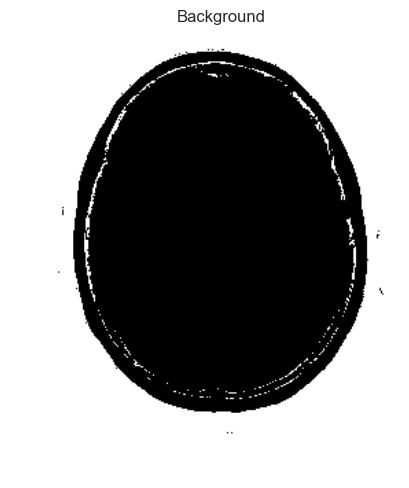

In [3]:
# conservative background mask (use the sum of the uncorrected t1 and t2 data)
background = signal_likelihood(t1+t2) < 0.7

z = 120
plt.imshow(background[:,::-1,z].transpose(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('Background')

In [4]:
# Compute the coil correction using the sum of T1 and T2 as the reference
c = coil_correction(t1+t2)

# Correct the intensities
ct1 = c*t1
ct2 = c*t2

In [5]:
# Compute the textures for the intensity corrected T1 and T2 data
scales = [1, 2, 4, 8]

t1_textures, t1_labels = textures(ct1, scales, 't1')
t2_textures, t2_labels = textures(ct2, scales, 't2')
ns = t1_textures.shape[-1]

In [6]:
def select(d, m=None):
    if isinstance(d, list):
        h = []
        for dsub in d:
            h.append(select(dsub, m))
        return np.hstack(h)
    else:
        if m is not None:
            return d.reshape(-1,d.shape[-1])[m.flatten(),:]
        else:
            return d.reshape(-1,d.shape[-1])

In [14]:
# Create a linear classifier to separate CSF from gray and white
# intensity based only because the ventricle and the csf around the brain
# have very different structure
bkg_signal = select([t1_textures, t2_textures], background)[::100,:]
csf_signal = select([t1_textures, t2_textures], csf)
gray_signal = select([t1_textures, t2_textures], gray)[::50,:]
white_signal =  select([t1_textures, t2_textures], white)[::50,:]

nbkg = bkg_signal.shape[0]
ncsf = csf_signal.shape[0]
ngray = gray_signal.shape[0]
nwhite = white_signal.shape[0]
Xtrain = np.vstack((bkg_signal, csf_signal, gray_signal, white_signal))
ytrain = np.zeros([nbkg+ncsf+ngray+nwhite,])

ytrain[:nbkg] = 0
ytrain[nbkg:nbkg+ncsf] = 1
ytrain[nbkg+ncsf:nbkg+ncsf+ngray] = 2
ytrain[nbkg+ncsf+ngray:] = 3

csf_classifier = LogisticRegression(penalty='l2', solver='sag', max_iter=100, multi_class='multinomial')
csf_classifier.fit(Xtrain, ytrain)

/Users/souheil/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

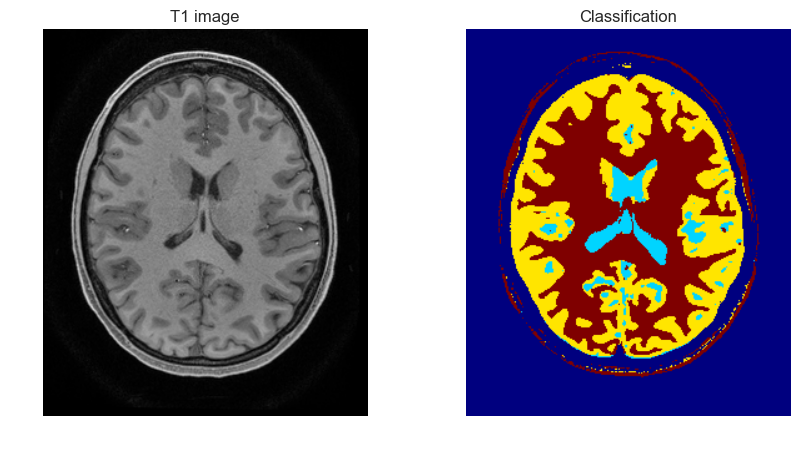

In [12]:
slice_signal = select([t1_textures[:,:,z,:], t2_textures[:,:,z,:]])

csf_pred = csf_classifier.predict(slice_signal)
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(ct1[:,::-1,z].transpose(), cmap='gray')
plt.axis('off')
plt.title('T1 image')
plt.subplot(1,2,2)
plt.imshow(csf_pred.reshape([nx,ny])[:,::-1].transpose(), cmap='jet')
plt.axis('off')
plt.title('Classification')

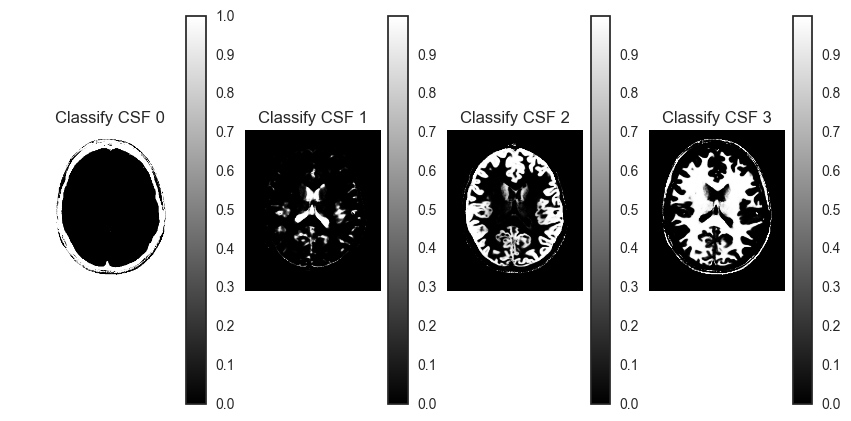

In [9]:
csf_pred = csf_classifier.predict_proba(slice_signal).reshape([nx,ny,4])
#mask = 1-background[:,::-1,z].transpose()
plt.figure(figsize=[10,5])
plt.subplot(1,4,1)
plt.imshow(csf_pred[:,::-1,0].transpose(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('P(background)')
plt.subplot(1,4,2)
plt.imshow(csf_pred[:,::-1,1].transpose(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('P(csf)')
plt.subplot(1,4,3)
plt.imshow(csf_pred[:,::-1,2].transpose(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('P(gray)')
plt.subplot(1,4,4)
plt.imshow(csf_pred[:,::-1,3].transpose(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('P(white)')